In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from PIL import Image
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
!pip install torchsummary

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#데이터 불러오기
path_dir=("/content/drive/MyDrive/인공지능 실습/IMS_인공지능스터디/DataSet/Dataset")

# 파일 조회
all_files = os.listdir(path_dir)

# 파일 이름에 'o'와 'x'로 나누기
o_images = [file for file in all_files if 'o' in file]
x_images = [file for file in all_files if 'x' in file]

print('o_images:', len(o_images)) # 왜 너만 141이야 분명 140맞는데!
print('x_images:', len(x_images))


o_images: 141
x_images: 140


In [ ]:
#이미지 전처리
def preprocess_image(path_dir):
  images=[]
  labels=[]

  all_files = os.listdir(path_dir)

  for filename in all_files:
    if filename.endswith((".jpg", ".png")):
      img_path=os.path.join(path_dir, filename)
      try:
        img=Image.open(img_path)
        img = img.convert('RGB')  # 이미지를 RGB로 변환
        img=img.resize((224, 224)) #224*224
        transform = transforms.Compose([
                    transforms.ToTensor(),  # 이미지를 텐서로 변환
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 이미지 정규화
                ])
        img = transform(img)
        images.append(img)

        if 'o' in filename:
          labels.append(0) # o는 0
        elif 'x' in filename:
          labels.append(1) # x는 1
      except PIL.UnidentifiedImageError:
        print(f"failed to load image: {filename}")


  images = torch.stack(images)  # 이미지 리스트를 텐서로 변환
  labels = torch.tensor(labels)  # 레이블 리스트를 텐서로 변환

  return images, labels

images, labels= preprocess_image(path_dir)
print('Images shape:', images.size())
print('Labels shape:', labels.size())

Images shape: torch.Size([280, 3, 224, 224])
Labels shape: torch.Size([280])


- ox 전체 이미지 280
- 224*224 픽셀
- RGB 이므로 3채널
- label 총 280개, o->0, x->1

In [ ]:
#training-data 랑 test-data로 나누기
# train_ratio 8:2로 나눔
def split_dataset(images, labels, train_ratio=0.8):
 dataset= TensorDataset(images, labels) #텐서로 이미지랑 레이블을 하나로 결합
 train_size = int(train_ratio * len(dataset)) #train data 크기 계산
 test_size = len(dataset) - train_size #test data 크기 계산
 train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #train data와 test data로 random split
 return train_dataset, test_dataset

train_dataset, test_dataset = split_dataset(images, labels)
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

#모델에 데이터 전달(데이터 로더)
batch_size = 32
#학습데이터는 shuffle하고 테스트데이터는 안함
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train dataset size: 224
Test dataset size: 56


In [ ]:
#cnn 모델 정의
# conv - pooling - fully conneted layer(linear) - relu

class CNN(nn.Module):
    def __init__(self):
      super(CNN, self).__init__()
     #RGB이므로 3채널, out채널은 합성곱 필터의 출력 채널 수
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)#최대 풀링(이미지 인식 분야)
      #입력 특성의 수와 출력 특성의 수 정의
      self.fc1 = nn.Linear(128 * 28 * 28, 512) # 이전 합성곱 레이어의 출력 특성 수 이용해서 입력 특성수 정의
      self.fc2 = nn.Linear(512, 2) #최종적으로 분류할 클래스 수 맞춰서 출력 특성 정의
      #self.fc3= nn.Linear(32 * 56 * 56, 512)
      self.relu1 = nn.ReLU() #활성화 함수(비선형성 추가해서 복잡한 패턴 학습)
      #self.relu2 = nn.ReLU()
      self.dropout = nn.Dropout(p=0.5)
      self.bn1 = nn.BatchNorm2d(16)
      self.bn2 = nn.BatchNorm2d(64)
      self.bn3 = nn.BatchNorm2d(128)

#순전파 연산 - 차례대로 변수 계산하고 저장
    def forward(self, x):
      x=self.maxpool(torch.relu(self.conv1(x))) #conv1 합성곱 풀링 계산 후 저장
      x=self.maxpool(torch.relu(self.conv2(x))) #conv2 합성곱 풀링 계산 후 저장
      x=self.maxpool(torch.relu(self.conv3(x))) #conv3 합성곱 풀링 계산 후 저장
      x = x.view(-1, 128 * 28 * 28) # 텐서를 1차원으로 변환
      x = torch.relu(self.fc1(x)) #fc1 계산 후 저장
      x = self.dropout(x)
      x=self.fc2(x)
      return x

def create_model(): # create_model 함수는 이제 CNN 클래스의 인스턴스를 반환
  return CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device) # create_model 함수를 통해 CNN 인스턴스 생성

#모델 초기화
model = create_model().to(device)
#손실함수 - 출력과 실제 사이의 엔트로피 손실 계산
criterion = nn.CrossEntropyLoss()
#옵티마이저 - 최적화 알고리즘을 사용하여 모델의 파라미터를 업데이트, lr은 학습률(가중치 업데이트 속도와 방향 결정)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # 최적화 함수 변경

Epoch 1/20, Loss: 0.6915334974016462


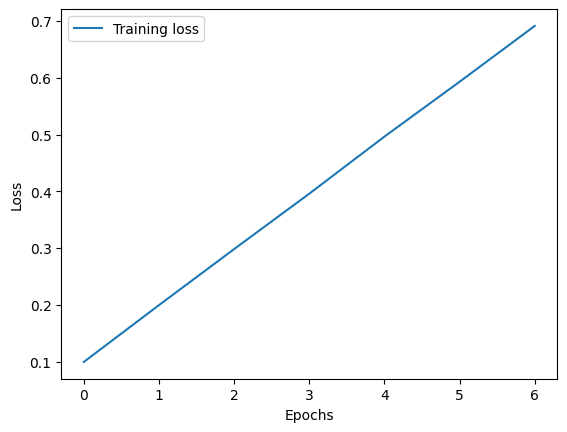

Epoch 2/20, Loss: 0.6847330587250846


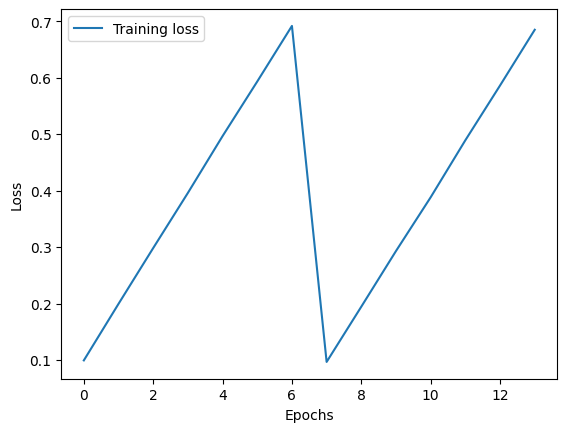

Epoch 3/20, Loss: 0.685276882989066


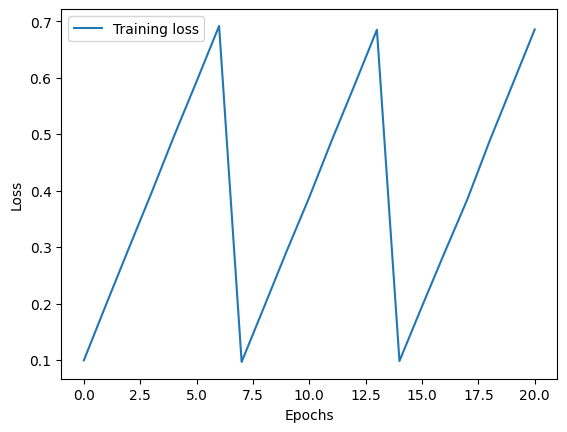

Epoch 4/20, Loss: 0.6561715858323234


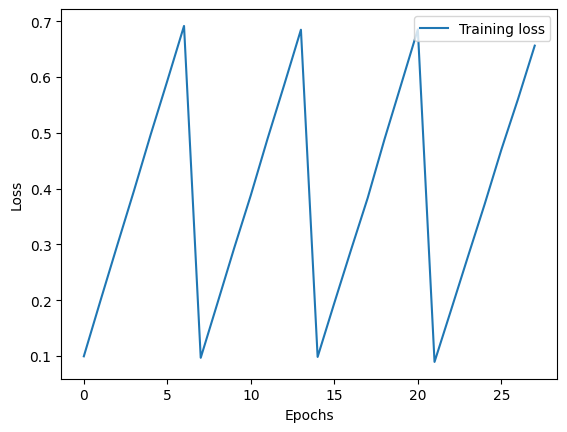

Epoch 5/20, Loss: 0.6287170733724322


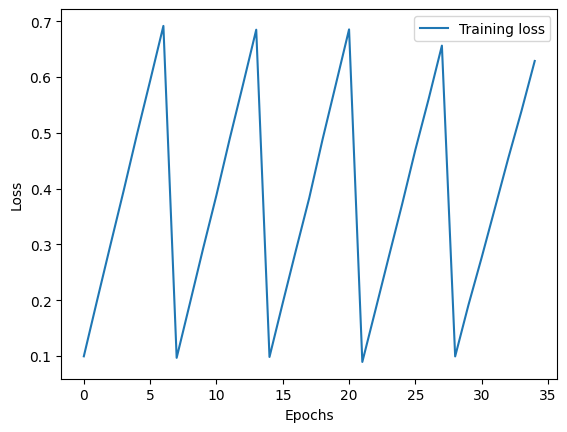

Epoch 6/20, Loss: 0.5577029160090855


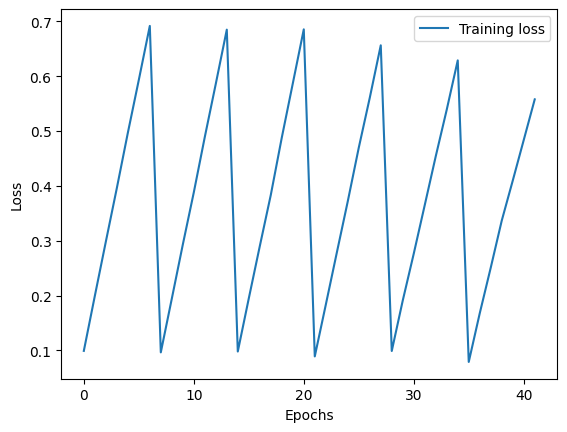

Epoch 7/20, Loss: 0.47650530082838877


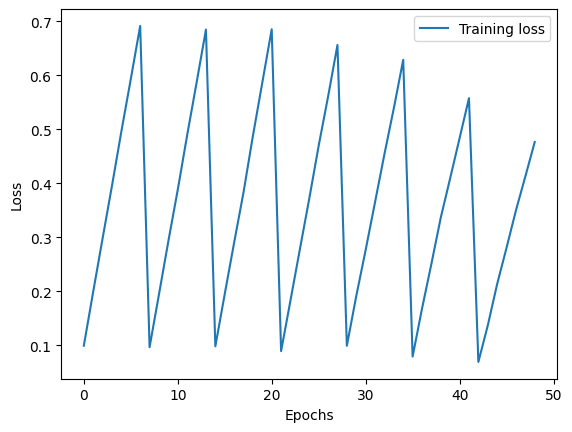

Epoch 8/20, Loss: 0.42604165417807444


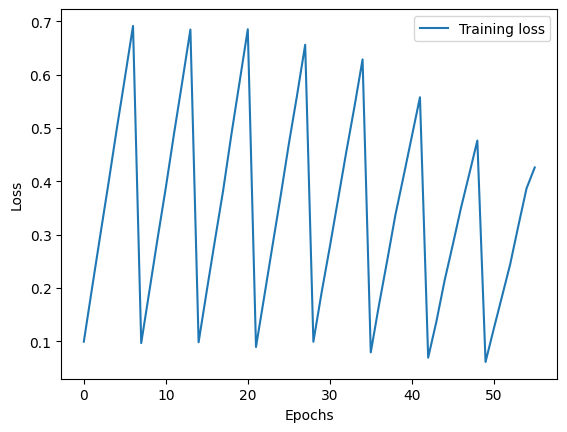

Epoch 9/20, Loss: 0.3738808717046465


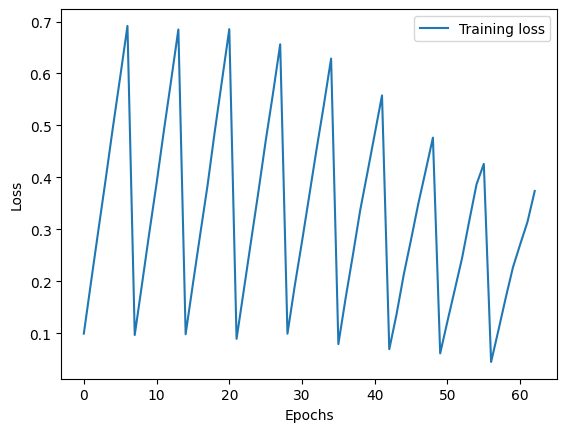

Epoch 10/20, Loss: 0.33336386510304045


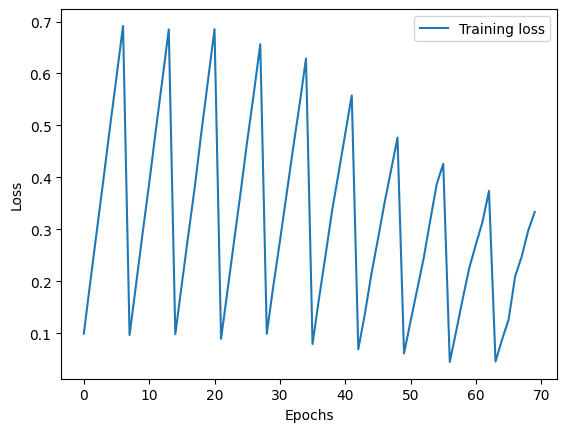

Epoch 11/20, Loss: 0.2688098762716566


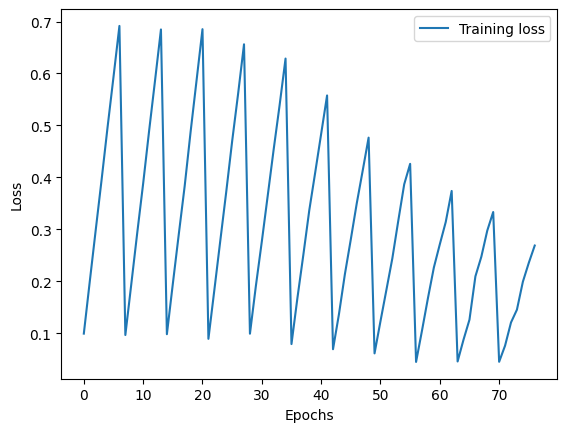

Epoch 12/20, Loss: 0.28818716534546446


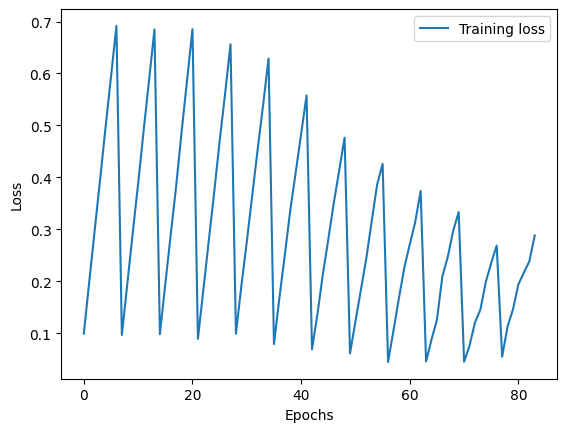

Epoch 13/20, Loss: 0.24892028953347886


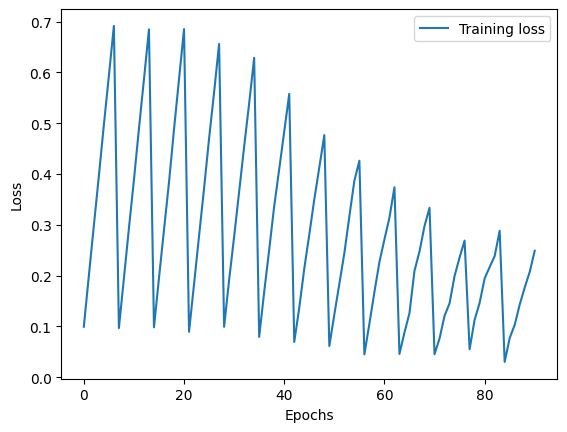

Epoch 14/20, Loss: 0.1838760216321264


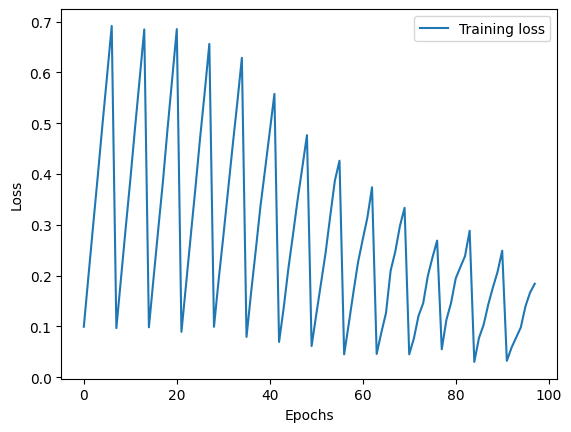

Epoch 15/20, Loss: 0.16080754569598607


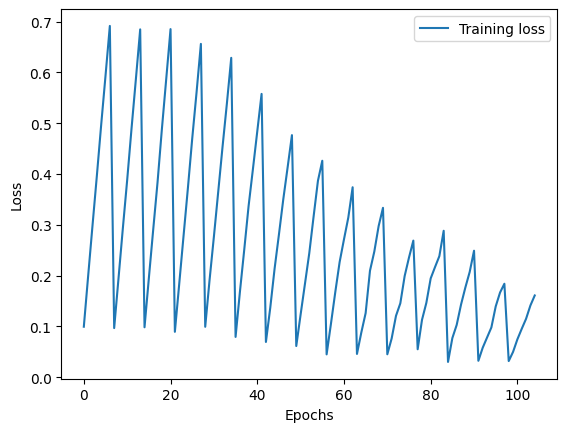

Epoch 16/20, Loss: 0.13066109269857407


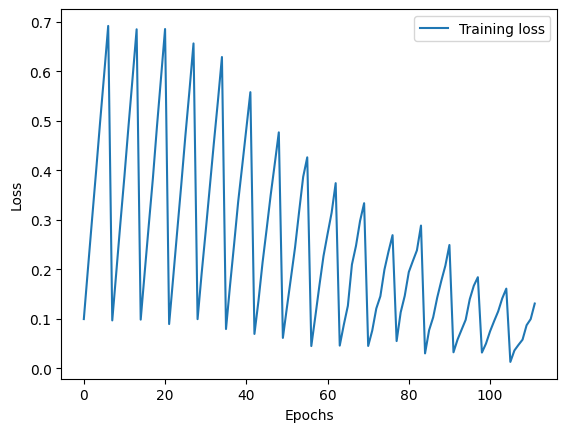

Epoch 17/20, Loss: 0.12427508405276708


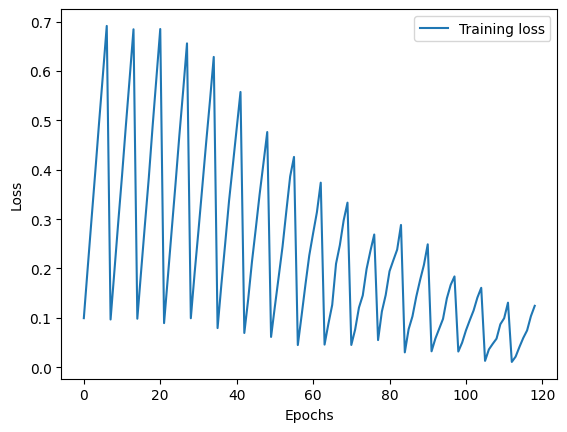

Epoch 18/20, Loss: 0.10483082649963242


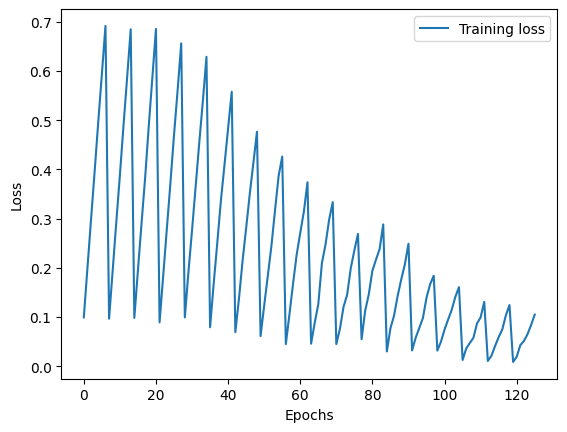

Epoch 19/20, Loss: 0.08932463478829179


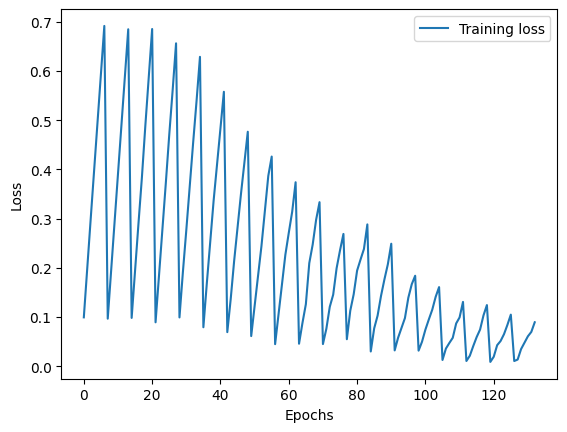

Epoch 20/20, Loss: 0.05440712799983365


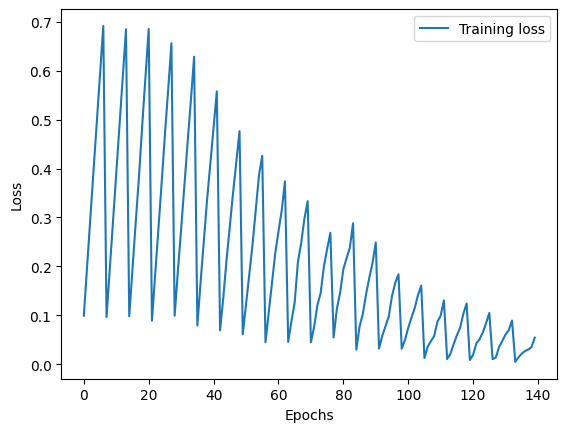

Accuracy: 85.71428571428571%


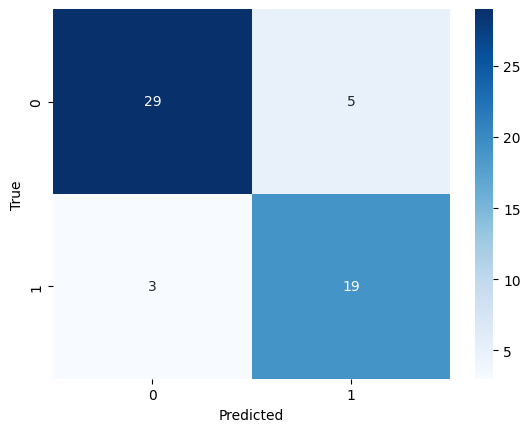

              precision    recall  f1-score   support

           0       0.91      0.85      0.88        34
           1       0.79      0.86      0.83        22

    accuracy                           0.86        56
   macro avg       0.85      0.86      0.85        56
weighted avg       0.86      0.86      0.86        56

              precision    recall  f1-score   support

 Class 0 (o)       0.91      0.85      0.88        34
 Class 1 (x)       0.79      0.86      0.83        22

    accuracy                           0.86        56
   macro avg       0.85      0.86      0.85        56
weighted avg       0.86      0.86      0.86        56



85.71428571428571

In [ ]:
#모델 훈련
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
  model.train()
  train_losses = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs) #입력 데이터 전달해서 출력 계산
      loss = criterion(outputs, labels) # loss 계산(출력 - 실제)
      loss.backward() #역전파 - 파라미터에 대한 loss기울기 계산
      optimizer.step() #파라미터 업데이트
      #epoch 내에 러닝 손실 계산, 출력
      running_loss += loss.item()

      epoch_loss = running_loss / len(train_loader)
      train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    plt.plot(train_losses, label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#모델 평가
def evaluate_model(model, test_loader, criterion):
  model.eval()
  correct = 0
  total = 0
  y_true = []
  y_pred = []

  with torch.no_grad(): #평가시 기울기 계산 안함
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1) #최대값과 최대값의 인덱스 반환
      total += labels.size(0) #배치 크기만큼 더함
      correct += (predicted == labels).sum().item() #예측값과 실제값이 같은지 확인
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total #정확도 계산
    print(f"Accuracy: {accuracy}%")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(classification_report(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=['Class 0 (o)', 'Class 1 (x)']))
    return accuracy



#모델 훈련 , 평가
train_model(model, train_loader, criterion, optimizer, num_epochs=20)
evaluate_model(model, test_loader, criterion)

인공지능 3-1 과제
- 성능 제일 좋게.
- batch size, 활성화 함수
- fold?
- hidden layer. 뉴런 수 바꿔 가면서... 계층 수
- padding? stride..
- 최적화 함수
- 에폭
- kernel size
- 전처리할때 이미지 크기 (정규화)
- 채널 크기
- 안한게  뭐가있지?
- 학습률?
- 웅 마자 정답!
- 모델 저장